# Models
## Exploring and Predicting EV Registration Data

Daniel Gieseke | August 2023

The electric vehicle (EV) industry is booming at every level, and companies in the burgeoning industry are aiming to understand the different factors that affect EV adoption, and the geographic spread of EVs such that they can adequately prepare and market themselves.  This project aims to take in real world data on EV registrations by zip code along with several socioeconomic factors to find respective variance and correlation, and ultimately build a machine learning model that can predict EV registration by zip code; with these models we aim to understand the factors that affect EV adoption.

**About this notebook**

This notebook contains the machine learning models developed in conjunction with this project.  For details on EDA and data preparation, please visit my other notebooks on GitHub.

### Importing Libraries

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid", {"font.family": "Helvetica"})
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from uszipcode import SearchEngine
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import mpu
import zipcodes
import warnings
warnings.filterwarnings("ignore")

### Importing EV Registration Data and Performing Light Cleaning

In [3]:
# Importing Data
df = pd.read_csv('Cleaned_EV_Reg_Data')

# Dropping Unneeded Row
df = df.drop(columns='Unnamed: 0')

# Converting ZIP Column to STR
df['ZIP Code'] = df['ZIP Code'].astype(str)

In [4]:
# Cleaning ZIP Column
dirty_zips = df['ZIP Code']
clean_zips = []

for code in dirty_zips:
    if len(code) < 5:
        new_code = '0' + code
        clean_zips.append(new_code)
    else:
        clean_zips.append(code)

df['ZIP Code'] = clean_zips

In [6]:
# Adding State Column
conditions = [
    df['NY'] == 1,
    df['NJ'] == 1,
    df['CT'] == 1,
]

outputs = [
    'New York', 'New Jersey', 'Connecticut'
]

In [7]:
df['State'] = np.select(conditions, outputs)

In [8]:
# Creating "TIME" df by Joining 2022 data
df_2022 = pd.read_csv('Cleaned_EV_Reg_Data_2022')

# Converting ZIP Column to STR
df_2022['ZIP Code'] = df_2022['ZIP Code'].astype(str)

# Cleaning ZIP Column
dirty_zips = df_2022['ZIP Code']
clean_zips = []

for code in dirty_zips:
    if len(code) < 5:
        new_code = '0' + code
        clean_zips.append(new_code)
    else:
        clean_zips.append(code)

df_2022['ZIP Code'] = clean_zips

df_time = df.merge(df_2022, on='ZIP Code', how='left')

In [9]:
# Removing Connecticut from TIME df as CT doesn't have a wide breadth of EV data from 2022
df_time = df_time.dropna()

## Model 1 - Predicting Total EVs Registered in a ZIP Code - Linear Regression

Below I am performing a linear regression using first a model from the Statsmodels.api library, then performing a train test split using the scikit-learn library.  After finding my best features in my model using my Statsmodels.api model, I continued to tune my model with scikit-learn.  Eventually I received an R2 score of .82.

### Statsmodels.api

In [14]:
y = df['Vehicle Count']
X = df[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'high_pop', 'in_NYC', 'EV Charging Stations', 'CT', 
             'Percent Pop. Age 30-34', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income', 'NYC Suburb']]

In [15]:
model = sm.OLS(y, sm.add_constant(X))

In [16]:
results = model.fit()

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Vehicle Count   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     447.4
Date:                Tue, 25 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:                -14913.
No. Observations:                2614   AIC:                         2.986e+04
Df Residuals:                    2599   BIC:                         2.994e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -45.5490      6.938     -6.565      0.000     -59.153     -31.945
Median Family Household Income          0.0004   7.72e-05      5.311      0.000       0.000       0.001
Population                              0.0011      0.000      4.234      0.000       0.001       0.002
Percent Pop. Bachelors Deg. - 35-44     0.8237      0.094      8.783      0.000       0.640       1.008
high_pop                               56.0489      4.416     12.693      0.000      47.390      64.708
in_NYC                               -126.4879      6.939    -18.228      0.000    -140.095    -112.881
EV Charging Stations                    2.9784      0.511      5.825      0.000       1.976       3.981
CT                                    -16.6581      4.886     -3.409      0.001     -26.239      -7.077
Percent Pop. Age 30-34                 -2.7091      0.577     -4.693      0.000      -3.841      -1.577
High_Income                           -20.3448      8.859     -2.296      0.022     -37.717      -2.973
Young_Liberal                          -3.9192      0.591     -6.630      0.000      -5.078      -2.760
Income_Liberal                          0.0002   4.14e-05      5.807      0.000       0.000       0.000
Income_Pop                           3.555e-08   3.77e-09      9.433      0.000    2.82e-08    4.29e-08
Ed_Income                           -3.808e-08   2.34e-08     -1.630      0.103   -8.39e-08    7.72e-09
NYC Suburb                              8.8673      5.276      1.681      0.093      -1.479      19.213
==============================================================================
Omnibus:                     1027.629   Durbin-Watson:                   1.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9496.616
Skew:                           1.601   Prob(JB):                         0.00
Kurtosis:                      11.772   Cond. No.                     1.73e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### scikit-learn

In [19]:
y = df['Vehicle Count']
X = df[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'dist_NYC', 'high_pop', 'voted for joe', 'in_NYC', 'EV Charging Stations', 'CT', 
            'Percent Pop. Age 25-29', 'Percent Pop. Age 30-34', 'Percent Pop. Age 35-39', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income', 'NYC Suburb']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [20]:
ss = StandardScaler()

ss.fit(X_train)
X_standardized_train = ss.transform(X_train)
X_standardized_test = ss.transform(X_test)

In [23]:
lr_raw = LinearRegression()
lr_raw.fit(X_standardized_train, y_train)

# Below is the R2 of my model - as you can see, it is similar to my model built using "Statsmodels.api"
lr_raw.score(X_standardized_train, y_train)

0.7092233753974573

In [22]:
# Below are the coefficients of my scaled data - this tells me the most important features to my model
pd.Series(lr_raw.coef_, index = X.columns)

Median Family Household Income         19.449143
Population                             22.448374
Percent Pop. Bachelors Deg. - 35-44    21.438621
dist_NYC                                1.014338
high_pop                               26.029391
voted for joe                          -0.074234
in_NYC                                -35.641175
EV Charging Stations                    7.784948
CT                                     -4.214382
Percent Pop. Age 25-29                 -3.076848
Percent Pop. Age 30-34                 -7.671146
Percent Pop. Age 35-39                  2.261683
High_Income                            -9.538745
Young_Liberal                         -12.353849
Income_Liberal                         12.534051
Income_Pop                             80.251302
Ed_Income                             -14.045268
NYC Suburb                              4.048217
dtype: float64

In [26]:
# Instantiating and Fitting a MinMaxScaler
scale = MinMaxScaler()
X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

In [27]:
# Instantiating a ridge, lasso and regular linear regression model  
# Note that in scikit-learn, the regularization parameter is denoted by alpha (and not lambda)
ridge = Ridge(alpha=0.5)
ridge.fit(X_train_transformed, y_train)

lasso = Lasso(alpha=0.5)
lasso.fit(X_train_transformed, y_train)

lin = LinearRegression()
lin.fit(X_train_transformed, y_train)

LinearRegression()

In [28]:
# Instantiating and Fitting Polynomial Features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_transformed = scale.fit_transform(X_train_poly)
X_test_transformed = scale.transform(X_test_poly)

# Fitting the models
ridge.fit(X_train_transformed, y_train)
lasso.fit(X_train_transformed, y_train)
lin.fit(X_train_transformed, y_train)

# Generating predictions
y_h_ridge_train = ridge.predict(X_train_transformed)
y_h_ridge_test = ridge.predict(X_test_transformed)
y_h_lasso_train = lasso.predict(X_train_transformed)
y_h_lasso_test = lasso.predict(X_test_transformed)
y_h_lin_train = lin.predict(X_train_transformed)
y_h_lin_test = lin.predict(X_test_transformed)

# Displaying results
print('Train Error Polynomial Ridge Model', mean_squared_error(y_train, y_h_ridge_train))
print('Test Error Polynomial Ridge Model', mean_squared_error(y_test, y_h_ridge_test))
print('\n')
print('Train Error Polynomial Lasso Model', mean_squared_error(y_train, y_h_lasso_train))
print('Test Error Polynomial Lasso Model', mean_squared_error(y_test, y_h_lasso_test))
print('\n')
print('Train Error Unpenalized Polynomial Model', mean_squared_error(y_train, y_h_lin_train))
print('Test Error Unpenalized Polynomial Model', mean_squared_error(y_test, y_h_lin_test))
print('\n')
print('Polynomial Ridge Parameter Coefficients:', len(ridge.coef_[ridge.coef_ != 0]), 
      'non-zero coefficient(s) and', len(ridge.coef_[ridge.coef_ == 0]), 'zeroed-out coefficient(s)')
print('Polynomial Lasso Parameter Coefficients:',  len(lasso.coef_[lasso.coef_ != 0]), 
      'non-zero coefficient(s) and', len(lasso.coef_[lasso.coef_ == 0]), 'zeroed-out coefficient(s)')
print('Polynomial Model Parameter Coefficients:',  len(lin.coef_[lin.coef_ != 0]), 
      'non-zero coefficient(s) and', len(lin.coef_[lin.coef_ == 0]), 'zeroed-out coefficient(s)')

Train Error Polynomial Ridge Model 2518.052701790818
Test Error Polynomial Ridge Model 3202.7046699993016


Train Error Polynomial Lasso Model 3641.34295669839
Test Error Polynomial Lasso Model 3897.707155345235


Train Error Unpenalized Polynomial Model 2224.428525627668
Test Error Unpenalized Polynomial Model 3534.6145096645973


Polynomial Ridge Parameter Coefficients: 187 non-zero coefficient(s) and 3 zeroed-out coefficient(s)
Polynomial Lasso Parameter Coefficients: 22 non-zero coefficient(s) and 168 zeroed-out coefficient(s)
Polynomial Model Parameter Coefficients: 190 non-zero coefficient(s) and 0 zeroed-out coefficient(s)


In [30]:
# Printing the R2 score for my model with Polynomial features
r2 = r2_score(y_true = y_test, y_pred = y_h_ridge_test)
print(r2)

0.8232544755774512


## Model 2 - Predicting EVs per Capita by ZIP Code - Categorical Classifier

This second simple model is a categorical classifier where, instead of predicting the total number of EV registrations in a zip code, I am predicting the number of EV registrations per capita (number of EVs per 100,000 people).  The target is separated into three categories: (1) if a zip code has a below-average number of EVs per 100k, (2) if a zip code has an above average number of EVs per 100k, and (3) if a zip code has a very high number of EVs per capita.  I determined these targets after analyzing the spread of my target variable below.

Median EVs per capita in Data Set: 606.3505135880629


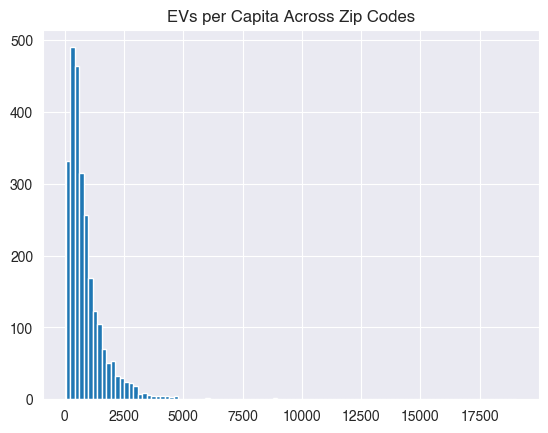

In [34]:
df['EVs per capita'].hist(bins=100).set(Title='EVs per Capita Across Zip Codes')
print("Median EVs per capita in Data Set:", df['EVs per capita'].median());

In [36]:
y = df['High EVs Per Capita']
X = df[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'dist_NYC', 'high_pop', 'voted for joe', 'in_NYC', 'EV Charging Stations', 'NY', 'CT', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income', 'NYC Suburb']]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [38]:
# Build a pipeline with StandardScaler and RandomForestClassifier
scaled_pipeline_2 = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier(random_state = 42))])

In [39]:
# Fit the training data to pipeline
scaled_pipeline_2.fit(X_train, y_train)

# Print the accuracy on test set
print("Accuracy Score of Training Data:", scaled_pipeline_2.score(X_train, y_train))
print("Accuracy Score of Test Data:", scaled_pipeline_2.score(X_test, y_test))

Accuracy Score of Training Data: 1.0
Accuracy Score of Test Data: 0.8191082802547771


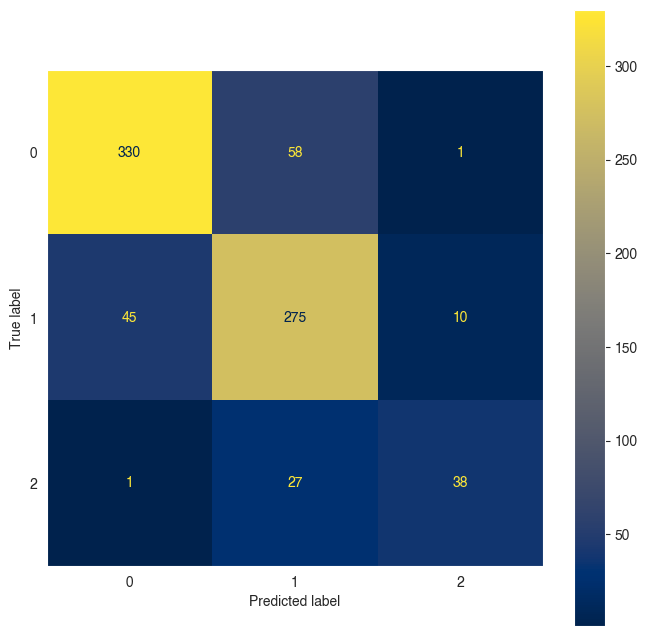

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(scaled_pipeline_2, X_test, y_test, ax=ax, cmap="cividis");

In [45]:
# Finding Feature Importance from Our Random Forest Model
importances = scaled_pipeline_2.named_steps['RF'].feature_importances_

# Creating List of Tuples with Feature Names and Importances
feature_importances = [(feature, importance) for feature, importance in zip(X.columns, importances)]
feature_importances

[('Median Family Household Income', 0.20649274003812393),
 ('Population', 0.09299206254732802),
 ('Percent Pop. Bachelors Deg. - 35-44', 0.1739104202289781),
 ('dist_NYC', 0.10180314956192542),
 ('high_pop', 0.007649452446124421),
 ('voted for joe', 0.005909776136349354),
 ('in_NYC', 0.019476381183899313),
 ('EV Charging Stations', 0.027296840034245467),
 ('NY', 0.013270201236316831),
 ('CT', 0.005256044570709494),
 ('High_Income', 0.014717199388484169),
 ('Young_Liberal', 0.05157258389232686),
 ('Income_Liberal', 0.10299090947701771),
 ('Income_Pop', 0.08067121110572131),
 ('Ed_Income', 0.08077032035907397),
 ('NYC Suburb', 0.015220707793375522)]

## Model 3 - Predicting Rise EVs per Capita by ZIP Code in 2022 - Linear Regression

My last model predicts the rise of EVs per capita by ZIP code in 2022.  Historically there has been a trend of early adoption of EV by wealthier individuals, by limiting this target to EV adoption in 2022, we are aiming to see if median family household income is still the most important factor that leads to EV adoption, or if other factors are now at play.

In [47]:
df_time['EVs Added in 2022'] = df_time['Vehicle Count_x'] - df_time['Vehicle Count_y']

In [68]:
y = df_time['EVs Added in 2022']
X = df_time[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'dist_NYC', 'high_pop', 'voted for joe', 'in_NYC', 'EV Charging Stations',
            'Percent Pop. Age 25-29', 'Percent Pop. Age 30-34', 'Percent Pop. Age 35-39', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income', 'NYC Suburb']]

In [69]:
model = sm.OLS(y, sm.add_constant(X))

In [70]:
results = model.fit()

In [71]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      EVs Added in 2022   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     241.2
Date:                Tue, 25 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:51:48   Log-Likelihood:                -13452.
No. Observations:                2862   AIC:                         2.694e+04
Df Residuals:                    2844   BIC:                         2.705e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -10.0415      4.157     -2.415      0.016     -18.193      -1.890
Median Family Household Income          0.0001   3.24e-05      3.296      0.001    4.33e-05       0.000
Population                              0.0006   8.75e-05      6.897      0.000       0.000       0.001
Percent Pop. Bachelors Deg. - 35-44     0.3222      0.035      9.285      0.000       0.254       0.390
dist_NYC                               -0.0171      0.005     -3.745      0.000      -0.026      -0.008
high_pop                               15.0565      1.533      9.821      0.000      12.050      18.063
voted for joe                           3.2707      4.198      0.779      0.436      -4.961      11.502
in_NYC                                -37.1297      2.316    -16.033      0.000     -41.671     -32.589
EV Charging Stations                    0.5314      0.149      3.570      0.000       0.240       0.823
Percent Pop. Age 25-29                 -0.4381      0.283     -1.549      0.122      -0.993       0.117
Percent Pop. Age 30-34                 -0.9070      0.211     -4.298      0.000      -1.321      -0.493
Percent Pop. Age 35-39                  0.3219      0.220      1.463      0.144      -0.110       0.753
High_Income                           -16.9027      3.158     -5.352      0.000     -23.095     -10.710
Young_Liberal                          -1.2321      0.367     -3.355      0.001      -1.952      -0.512
Income_Liberal                       6.046e-05   3.01e-05      2.008      0.045    1.42e-06       0.000
Income_Pop                           6.694e-09   1.18e-09      5.650      0.000    4.37e-09    9.02e-09
Ed_Income                            -7.21e-09    7.3e-09     -0.988      0.323   -2.15e-08     7.1e-09
NYC Suburb                             -3.9662      1.751     -2.265      0.024      -7.400      -0.533
==============================================================================
Omnibus:                     1898.322   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52563.007
Skew:                           2.722   Prob(JB):                         0.00
Kurtosis:                      23.277   Cond. No.                     3.09e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [73]:
ss = StandardScaler()

ss.fit(X_train)
X_standardized_train = ss.transform(X_train)
X_standardized_test = ss.transform(X_test)

In [74]:
lr_raw = LinearRegression()
lr_raw.fit(X_standardized_train, y_train)
lr_raw.score(X_standardized_train, y_train)

0.5863020731193639

In [75]:
pd.Series(lr_raw.coef_, index = X.columns)

Median Family Household Income          5.469067
Population                             13.461886
Percent Pop. Bachelors Deg. - 35-44     7.038853
dist_NYC                               -2.002390
high_pop                                6.998596
voted for joe                           0.872372
in_NYC                                -10.507768
EV Charging Stations                    2.399894
Percent Pop. Age 25-29                 -1.555252
Percent Pop. Age 30-34                 -2.342661
Percent Pop. Age 35-39                  1.107888
High_Income                            -3.703294
Young_Liberal                          -4.848793
Income_Liberal                          4.816568
Income_Pop                             14.657819
Ed_Income                              -2.312270
NYC Suburb                             -1.390300
dtype: float64

## Summary - Comparing Model 1 and Model 3

It's important to note the difference in the importance of each scaled coefficient in Model 1 compared against Model 3.  Model 1 highlights the socioeconomic features that affect the total number of EVs currently in a ZIP code from the inception of EVs to present, whereas Model 3 highlights those that affected the growth of EVs in a ZIP code in 2022.  The smaller R2 and limited size of the coefficients in Model 3 using the same features tells us that income is no longer a leading factor in the adoption of EVs.  As we would assume with a contemporary internal combustion engine (ICE) vehicle, the population of a zip code is now the factor that most affects EV adoption.